### Khaiii 형태소 분석기 기반 텍스트 EDA

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)
from sklearn.linear_model            import LogisticRegression
from sklearn.model_selection         import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics                 import accuracy_score, recall_score, roc_auc_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [88]:
train = pd.read_csv('./new_train.csv', index_col=0)
dev = pd.read_csv('../../data/dev.hate.csv')
test = pd.read_csv('../../data/test.hate.no_label.csv')
train = pd.concat([train, dev], axis=0)

In [89]:
train.head()

,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,hate


In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8367 entries, 0 to 470
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  8367 non-null   object
 1   label     8367 non-null   object
dtypes: object(2)
memory usage: 196.1+ KB


In [91]:

import re
def cleanse(text):
    pattern = re.compile(r'\s+')
    text = re.sub(pattern, ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    return text
train['comments'] = train['comments'].apply(cleanse)



from pykospacing import spacing
train['comments'] = train['comments'].apply(spacing)



import kss
train['comments'] = train['comments'].apply(kss.split_sentences)
train['comments'] = [','.join(map(str, ls)) for ls in train['comments']]



from soynlp.normalizer import *
train['comments'] = [repeat_normalize(comment, num_repeats=2) for comment in train['comments']]


185                  ㅅㅅ 한게 자랑  ㅈㅅ로 그것도
185    독전에서 김주혁은 정말 연기 잘하던데  축하드립니다 ㅠㅠ
Name: comments, dtype: object
185                 ㅅㅅ 한 게 자랑 ㅈㅅ로 그것도
185    독전에서 김주혁은 정말 연기 잘하던데 축하드립니다 ㅠㅠ
Name: comments, dtype: object
185                 ㅅㅅ 한 게 자랑 ㅈㅅ로 그것도
185    독전에서 김주혁은 정말 연기 잘하던데 축하드립니다 ㅠㅠ
Name: comments, dtype: object
185                 ㅅㅅ 한 게 자랑 ㅈㅅ로 그것도
185    독전에서 김주혁은 정말 연기 잘하던데 축하드립니다 ㅠㅠ
Name: comments, dtype: object


In [92]:
# khai
from khaiii import KhaiiiApi; k = KhaiiiApi()
def k_tokenizer(text):
    k.analyze(text)
    return [word.lex for word in k.analyze(text)]

In [93]:
sentence = "안녕하세요 지금 늦은 새벽시간입니다 코딩만 엄청 하고있네요 ㅋㅋ"
k.analyze(tmp)
[str(word) for word in k.analyze(tmp)]

['안녕하세요\t안녕/NNG + 하/XSA + 세요/EC',
 '지금\t지금/MAG',
 '늦은\t늦/VA + 은/ETM',
 '새벽시간입니다\t새벽/NNG + 시간/NNG + 이/VCP + ㅂ니다/EC',
 '코딩만\t코딩/NNG + 만/JX',
 '엄청\t엄청/MAG',
 '하고있네요\t하/VV + 고/EC + 있/VX + 네요/EC',
 'ㅋㅋ\tㅋㅋ/NNG']

In [94]:
comments_pos = []
for sent in train.comments:
    pos_tagged = ''
    for word in k.analyze(sent):
        for morph in word.morphs:
            pos_tagged += morph.lex + '/' + morph.tag + ' '
    comments_pos.append(pos_tagged)

In [95]:
train['comment_pos'] = comments_pos
train.head()

,comments,label,comment_pos
0,현재 호텔 주인 심정 아18 난 마른 하늘에 날벼락 맞고 호텔 망하게 생겼는데 누군...,hate,현재/MAG 호텔/NNG 주인/NNG 심정/NNG 아/NNG 18/SN 나/VA ㄴ...
1,한국적인 미인의 대표적인 분 너무나 곱고 아름다운 모습 그 모습 뒤의 슬픔을 미 처...,none,한국/NNP 적/XSN 이/VCP ㄴ/ETM 미인/NNG 의/JKG 대표/NNG 적...
2,못된 넘들 남의 고통을 즐겼던 넘들 이젠 마땅한 처벌을 받아야지 그래야 공정한 사회...,hate,못/MAG 되/VA ㄴ/ETM 넘/NNG 들/XSN 남/NNG 의/JKG 고통/NN...
3,1 2 화 어설 펐는데 3 4 화 지나서부터는 갈수록 너무 재밌던 데,none,1/SN 2/SN 화/NNB 어설/NNG 푸/VV 었/EP 는데/EC 3/SN 4/...
4,1 사람 얼굴 손톱으로 긁은 것은 인격 살해이고 2 동영상이 몰카냐 메걸리안 들 생...,hate,1/SN 사람/NNG 얼굴/NNG 손톱/NNG 으로/JKB 긁/VV 은/ETM 것/...


In [106]:
comments_pos = []
for sent in test.comments:
    pos_tagged = ''
    for word in k.analyze(sent):
        for morph in word.morphs:
            pos_tagged += morph.lex + '/' + morph.tag + ' '
    comments_pos.append(pos_tagged)
test['comments'] = comments_pos
test.head()

,comments
0,ㅋㅋㅋ/IC ㅋ/NNG 그러/VV 어도/EC 조아/NNG 하/XSV 여/EC 주/V...
1,둘/NR 다/MAG 넘/VV 좋/VA 다/EC ~/SS 행복/NNG 하/XSV 시/...
2,근데/MAJ 만/NNG 원/NNP 이/NNG 하/XSV 는/ETM 현금/NNG 결제...
3,원곡/NNG 생각/NNG 하/XSV 나/NR 도/JX 안/MAG 나/VA 고/EC ...
4,장현승/NNP 얘/NNG 도/JX 참/MAG 이제/NNG ㄴ/JX 짠하/VA 다/E...


In [96]:
# 토큰수 계산후 토큰수 컬럼 추가
token_count = [len(comment.split()) for comment in train['comment_pos']]
train['token_count'] = token_count
train.head(3)

,comments,label,comment_pos,token_count
0,현재 호텔 주인 심정 아18 난 마른 하늘에 날벼락 맞고 호텔 망하게 생겼는데 누군...,hate,현재/MAG 호텔/NNG 주인/NNG 심정/NNG 아/NNG 18/SN 나/VA ㄴ...,28
1,한국적인 미인의 대표적인 분 너무나 곱고 아름다운 모습 그 모습 뒤의 슬픔을 미 처...,none,한국/NNP 적/XSN 이/VCP ㄴ/ETM 미인/NNG 의/JKG 대표/NNG 적...,31
2,못된 넘들 남의 고통을 즐겼던 넘들 이젠 마땅한 처벌을 받아야지 그래야 공정한 사회...,hate,못/MAG 되/VA ㄴ/ETM 넘/NNG 들/XSN 남/NNG 의/JKG 고통/NN...,36


In [97]:
# 데이터 프레임 분리
total_df = train.copy()
hate_df = train[train['label'] == 'hate']
offensive_df = train[train['label'] == 'offensive']
not_none_df = train[train['label'] != 'none']
none_df = train[train['label'] == 'none']

In [98]:
# 데이터프레임 토큰 수 추출하는 함수
def get_token_count(df):
    tokens = []
    for sentence in df['comment_pos']:
        words = sentence.split()
        for word in words:
            tokens.append(word)
    tmp = np.unique(np.array(tokens), return_counts=True)
    tokens_df = pd.DataFrame({"token" : tmp[0],
                             "count" : tmp[1]})
    tokens_df.sort_values("count", ascending=False, inplace=True)
    return tokens_df

In [99]:
total_tcounts = get_token_count(total_df)
hate_tcounts = get_token_count(hate_df)
offensive_tcounts = get_token_count(offensive_df)
not_none_tcounts = get_token_count(not_none_df)
none_tcounts = get_token_count(none_df)

In [100]:
total_tcounts.head(10)

,token,count
11589,이/VCP,3600
362,ㄴ/ETM,3424
11578,이/JKS,3221
1451,고/EC,3108
15570,하/XSV,2712
3507,는/ETM,2595
4494,들/XSN,2174
15566,하/VV,2028
4128,도/JX,2006
689,가/JKS,1960


Text(0.5, 1.0, 'HATE')

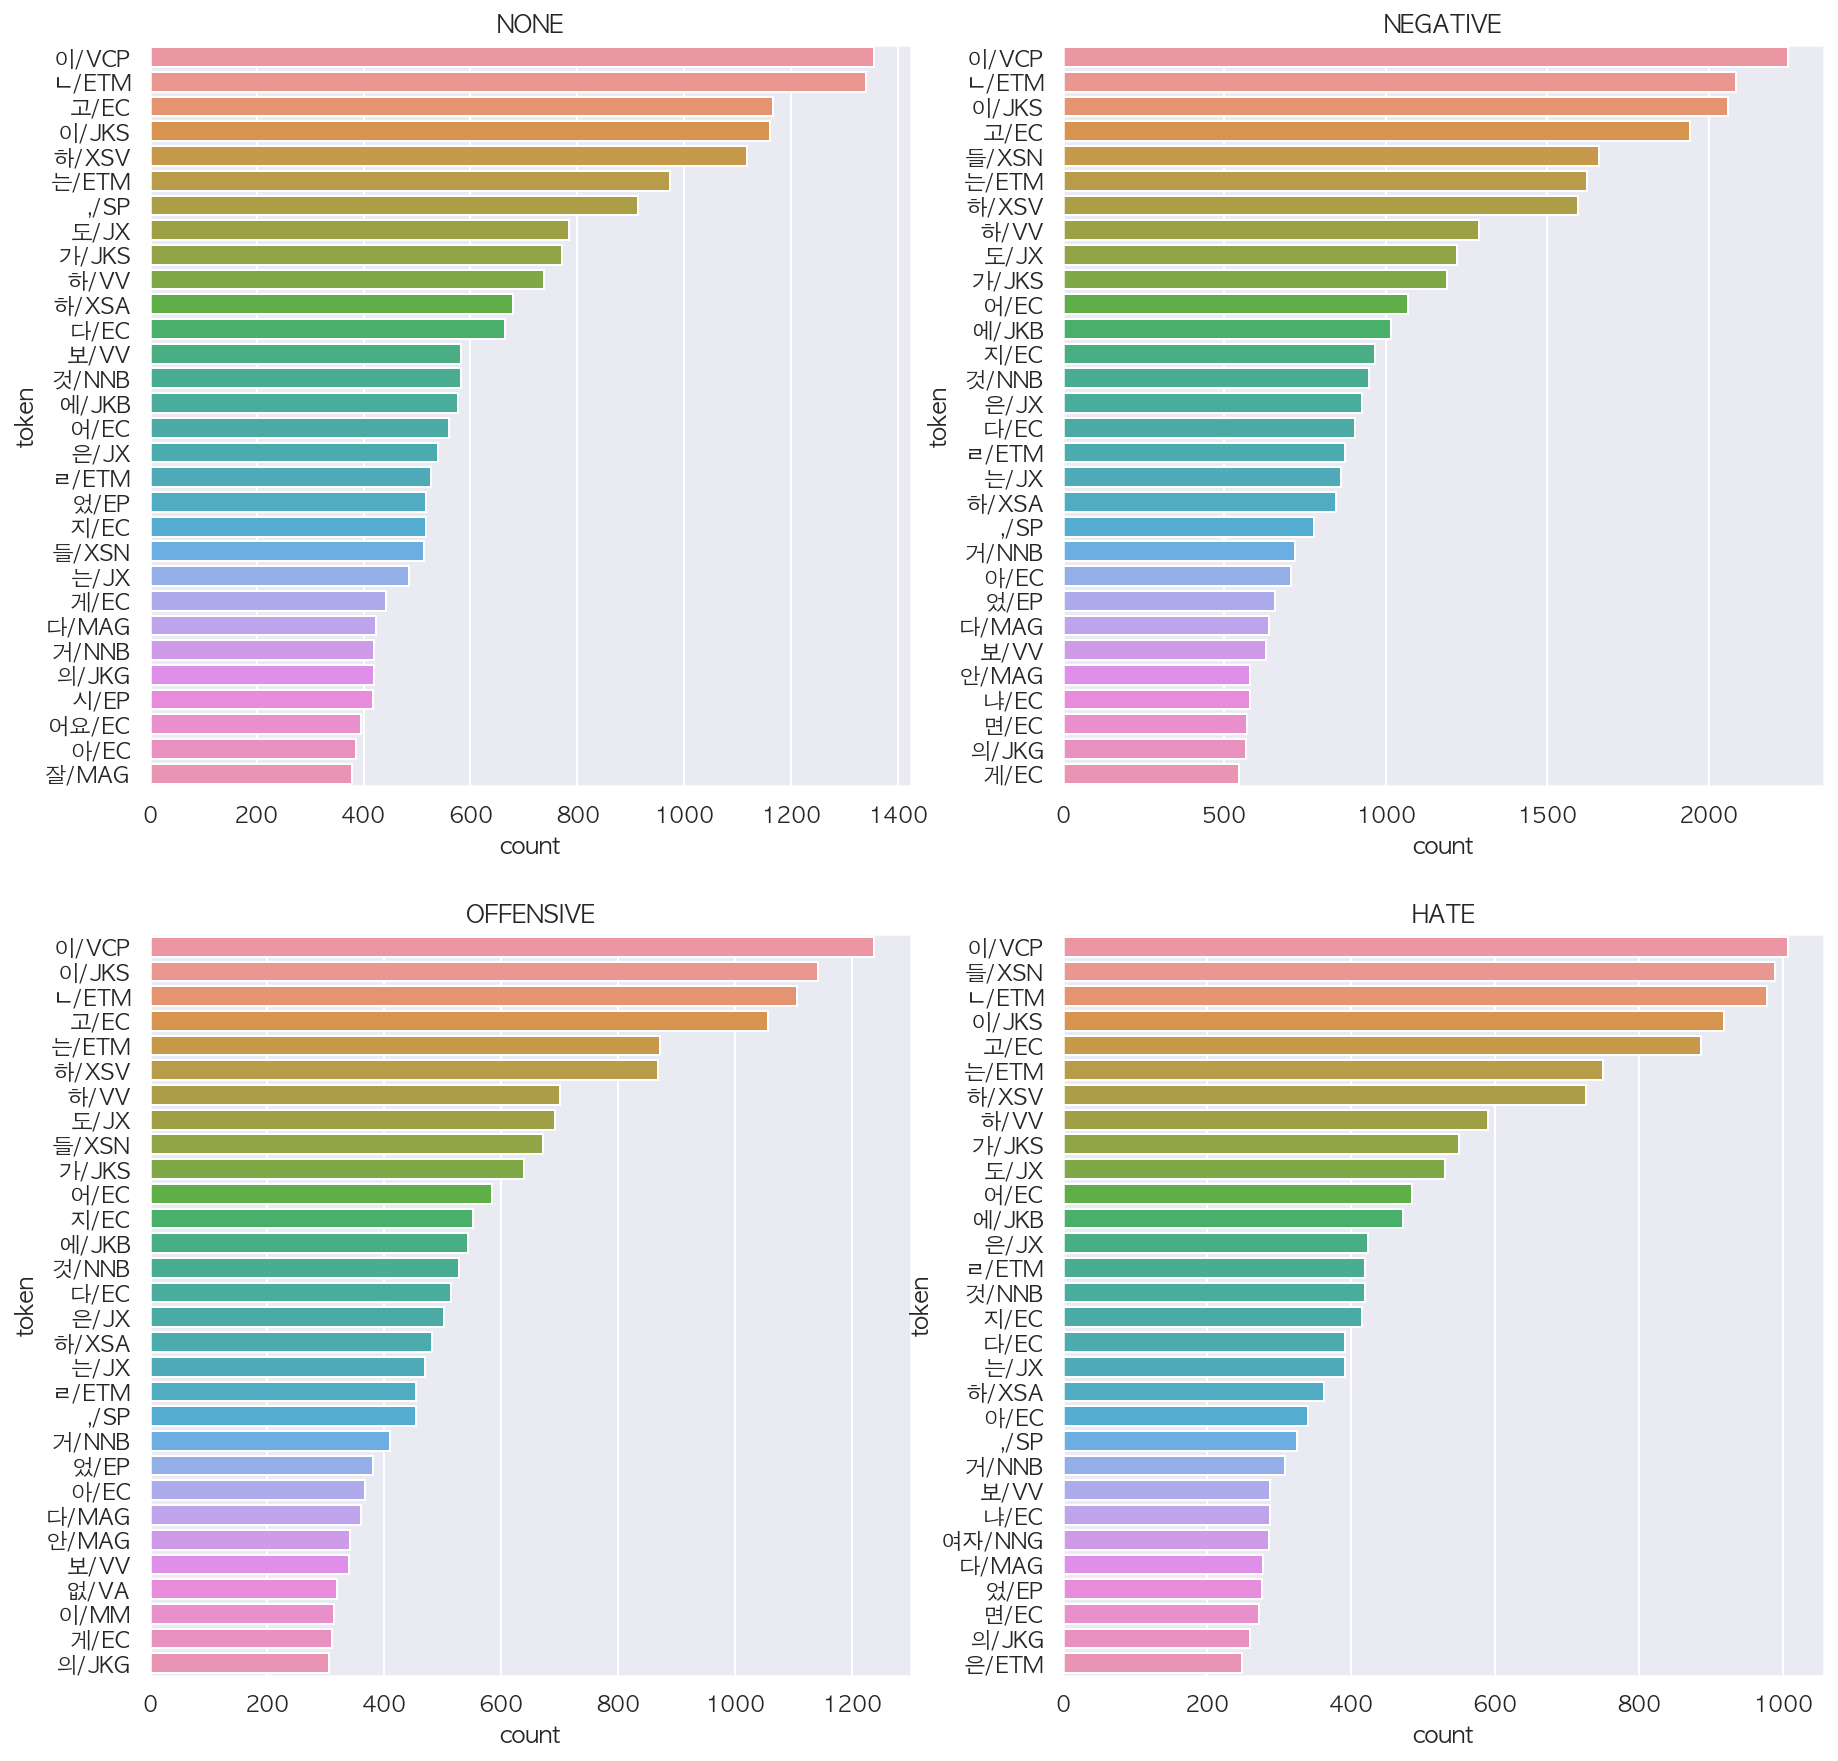

In [101]:
sns.set(font='AppleGothic', font_scale=1, rc={'figure.figsize':(15, 15)})
fig, axes = plt.subplots(2, 2)
sns.barplot(x='count', y='token', data=none_tcounts[:30], ax=axes[0,0])
axes[0,0].set_title('NONE')
sns.barplot(x='count', y='token', data=not_none_tcounts[:30], ax=axes[0,1])
axes[0,1].set_title('NEGATIVE')
sns.barplot(x='count', y='token', data=offensive_tcounts[:30], ax=axes[1,0])
axes[1,0].set_title('OFFENSIVE')
sns.barplot(x='count', y='token', data=hate_tcounts[:30], ax=axes[1,1])
axes[1,1].set_title('HATE')

In [103]:
stopwords = list(set(none_tcounts['token'][:30]) & set(offensive_tcounts['token'][:30]) & set(hate_tcounts['token'][:30]))

In [104]:
stopwords

['어/EC',
 '도/JX',
 '하/XSA',
 '것/NNB',
 '는/JX',
 '다/MAG',
 '고/EC',
 'ㄴ/ETM',
 '에/JKB',
 '의/JKG',
 '었/EP',
 '다/EC',
 '는/ETM',
 'ㄹ/ETM',
 '하/XSV',
 '보/VV',
 '지/EC',
 '하/VV',
 '아/EC',
 '이/JKS',
 '들/XSN',
 '가/JKS',
 '은/JX',
 '이/VCP',
 '거/NNB',
 ',/SP']

In [107]:
X_train = train['comments']
X_test = test['comments']
y_train = train['label']
# y_test = test['label']

# 벡터라이저 생성
tfidf_vect = TfidfVectorizer(analyzer='word', stop_words=stopwords,
                             ngram_range=(1,3))

# 벡터라이저 학습
tfidf_vect.fit(X_train)

# 벡터라이저 리턴
tfidf_matrix_train = tfidf_vect.transform(X_train)

# 로지스틱 리그레션 학습
lr = LogisticRegression(multi_class='multinomial', class_weight='balanced')
lr.fit(tfidf_matrix_train, y_train)

# 로지스틱 리그레션 예측
tfidf_matrix_test = tfidf_vect.transform(X_test)
preds = lr.predict(tfidf_matrix_test)
len(preds)
# accuracy_score(y_test, preds), f1_score(y_test, preds, average='macro')

/Users/jaecheolchoi/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ec', 'ep', 'etm', 'jkb', 'jkg', 'jks', 'jx', 'mag', 'nnb', 'sp', 'vcp', 'vv', 'xsa', 'xsn', 'xsv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


974

In [110]:
test['label'] = preds

In [111]:
def kaggle_format(df):
    df['label'][df['label'] == 'none'] = 0
    df['label'][df['label'] == 'offensive'] = 1
    df['label'][df['label'] == 'hate'] = 2
    return df

In [112]:
kaggle_format(test)

,comments,label
0,ㅋㅋㅋ/IC ㅋ/NNG 그러/VV 어도/EC 조아/NNG 하/XSV 여/EC 주/V...,2
1,둘/NR 다/MAG 넘/VV 좋/VA 다/EC ~/SS 행복/NNG 하/XSV 시/...,0
2,근데/MAJ 만/NNG 원/NNP 이/NNG 하/XSV 는/ETM 현금/NNG 결제...,0
3,원곡/NNG 생각/NNG 하/XSV 나/NR 도/JX 안/MAG 나/VA 고/EC ...,0
4,장현승/NNP 얘/NNG 도/JX 참/MAG 이제/NNG ㄴ/JX 짠하/VA 다/E...,0
...,...,...
969,대/MAG 박/NNG 게/NNG 스/NNP 트/NNG .../SE 꼭/MAG 보/V...,0
970,성형/NNG 으로/JKB 다/MAG 뜯어고치/VV 어/EC 놓/VX 고/EC 예쁘/...,2
971,분위기/NNG 는/JX 비슷/XR 하/XSA 다/EC 만/JX 전혀/MAG 다/VA...,0
972,입/NNG 에/JKB 손가릭/NNG 이/JKS 10/SN 개/NNB 있/VV 으니/...,0


In [113]:
test2 = pd.read_csv('../../data/test.hate.no_label.csv')
test['comments'] = test2['comments']

In [114]:
test.head()

,comments,label
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,2
1,둘다 넘 좋다~행복하세요,0
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,0
3,원곡생각하나도 안나고 러블리즈 신곡나온줄!!! 너무 예쁘게 잘봤어요,0
4,장현승 얘도 참 이젠 짠하다...,0


In [115]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  974 non-null    object
 1   label     974 non-null    object
dtypes: object(2)
memory usage: 15.3+ KB


In [116]:
test.to_csv('./0116_stopwords_jc.csv', index=False)

In [117]:
pd.read_csv('./0116_stopwords_jc.csv')

,comments,label
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,2
1,둘다 넘 좋다~행복하세요,0
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,0
3,원곡생각하나도 안나고 러블리즈 신곡나온줄!!! 너무 예쁘게 잘봤어요,0
4,장현승 얘도 참 이젠 짠하다...,0
...,...,...
969,대박 게스트... 꼭 봐야징~ 컨셉이 바뀌니깐 재미지넹,0
970,성형으로 다 뜯어고쳐놓고 예쁜척. 성형 전 니 얼굴 다 알고있다. 순자처럼 된장냄새...,2
971,분위기는 비슷하다만 전혀다른 전개던데 무슨ㅋㅋㄱ 우리나라사람들은 분위기만 비슷하면 ...,0
972,입에 손가릭이 10개 있으니 징그럽다,0
